<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Parcial_1_TAM_2025-1/notebooks/ElasticNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo 3: ElasticNet – Análisis, Validación y Evaluación

Este notebook forma parte del estudio comparativo de regresores sobre el conjunto de datos **Ames Housing**. En esta sección se desarrollará el modelo **ElasticNet**, el cual combina penalizaciones L1 (Lasso) y L2 (Ridge) para lograr un equilibrio entre selección de variables y regularización.

Se utilizarán las siguientes herramientas y criterios:

- **Validación cruzada con 5 folds** para evaluación consistente.
- **Búsqueda automática con ElasticNetCV** para estimar alpha y l1_ratio.
- **GridSearchCV** para ajuste fino.
- **Métricas de desempeño**: MAE, MSE, RMSE, R², MAPE.
- **Diagnóstico** de residuos, normalidad, autocorrelación.
- **Curva de aprendizaje**, **VIF**, y **análisis de coeficientes**.
- **Exportación de resultados y visualizaciones** para informes y comparación.

Este notebook reutiliza funciones y configuraciones previas (preprocesamiento, métricas personalizadas, estructura del proyecto y entorno de ejecución).


In [51]:
# === CLONAR EL REPOSITORIO Y LISTAR SU CONTENIDO ===

# Clona el repositorio desde GitHub si no se ha hecho previamente.
# Esto permite acceder a los notebooks, datos y estructuras organizadas del proyecto.
!git clone https://github.com/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina.git

fatal: destination path 'Teoria-de-Aprendizaje-Maquina' already exists and is not an empty directory.


In [52]:
# Lista el contenido del directorio del parcial dentro del repositorio clonado
# para confirmar que la estructura y carpeta 'data' existen correctamente.
!ls /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

dashboard  figuras    parte_teorica  requirements.txt  Teoria-de-Aprendizaje-Maquina
data	   notebooks  README.md      resultados


In [53]:
!ls /content/Teoria-de-Aprendizaje-Maquina

'Ejercicios TAM_2025-1'   Parcial_1_TAM_2025-1	 README.md


In [54]:
# === IMPORTACIÓN DE LIBRERÍAS Y CAMBIO DE DIRECTORIO ===

import os      # Para manipular rutas de archivos y cambiar directorios
import joblib  # Para cargar archivos serializados (como los .pkl que contienen los datos escalados)

# Cambia al directorio principal del proyecto clonado para que todas las rutas relativas sean válidas.
os.chdir('/content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1')

# Define la ruta al archivo que contiene los datos ya preprocesados, escalados y divididos.
data_path = 'data/train_test_scaled.pkl'

In [55]:
# Verifica que el archivo exista antes de intentar cargarlo, y lanza un error claro si no se encuentra.
if not os.path.exists(data_path):
    raise FileNotFoundError(f"No se encontró el archivo esperado en: {data_path}")

In [56]:
# === CARGA DE LOS DATOS PROCESADOS ===

# Carga el archivo .pkl que contiene los cuatro objetos: X_train_scaled, X_test_scaled, y_train, y_test
# Estos datos fueron escalados y divididos previamente en el notebook de preprocesamiento.
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path)

# Confirmación visual de que la carga fue exitosa.
print("Datos cargados correctamente.")

Datos cargados correctamente.


In [57]:
%cd /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

/content


In [58]:
# === IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE MÉTRICAS PERSONALIZADAS ===

# ================================================================
#  IMPORTACIONES COMPLETAS – ESTUDIO DE REGRESORES AMES HOUSING
# ================================================================

# ============================
#  Utilidades generales
# ============================
import numpy as np
import pandas as pd
import time
import os
import warnings
warnings.filterwarnings("ignore")  # Opcional: suprime warnings en notebooks

# ============================
#  Modelos de regresión
# ============================
from sklearn.linear_model import (
    LinearRegression,
    Lasso, LassoCV,
    ElasticNet, ElasticNetCV,
    SGDRegressor,
    BayesianRidge
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
# ============================
#  Validación y búsqueda
# ============================
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    cross_validate,
    cross_val_predict
)

# ============================
#  Métricas y scoring
# ============================
from sklearn.metrics import (
    mean_absolute_error,       # MAE
    mean_squared_error,        # MSE
    r2_score,                  # R²
    mean_absolute_percentage_error,  # MAPE
    make_scorer                # Para definir MAPE como scorer
)

# ============================
# Diagnóstico estadístico
# ============================
from scipy.stats import shapiro, kurtosis, skew
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ============================
#  Visualización
# ============================
import matplotlib.pyplot as plt
import scipy.stats as stats  # necesario para pruebas estadísticas
from matplotlib.ticker import FuncFormatter

import seaborn as sns

In [59]:
# === DEFINICIÓN DE MÉTRICA PERSONALIZADA: MAPE ===

# MAPE no está directamente disponible en sklearn, por lo que se define manualmente.
# Esta métrica mide el error absoluto medio en porcentaje, útil para interpretar desviaciones relativas.

def mean_absolute_percentage_error(y_true, y_pred):
    # Reemplaza ceros en y_true para evitar divisiones por cero (buena práctica numérica)
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Se integra la función MAPE a sklearn como un scorer compatible con cross_validate
# Se indica que un menor valor es mejor (greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


In [60]:
# === DEFINICIÓN DEL ESQUEMA DE VALIDACIÓN CRUZADA ===

# Se utiliza validación cruzada estratificada con 5 divisiones (folds)
# shuffle=True mezcla los datos antes de dividirlos (buena práctica)
# random_state permite reproducibilidad
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# === DEFINICIÓN DE MÉTRICAS DE EVALUACIÓN PARA TODOS LOS MODELOS ===

# Las métricas estándar (MAE y MSE) son negativas en sklearn por convención (porque se busca minimizar)
# R² se mantiene tal cual
# MAPE se incluye como scorer personalizado
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MAPE': mape_scorer
}

modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "BayesianRidge": BayesianRidge(),
    "KernelRidge": KernelRidge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GaussianProcess": GaussianProcessRegressor(),
    "SVR": SVR()
}


In [61]:
def evaluar_modelo_cv(nombre_modelo, modelo, X, y, cv, scoring, guardar_en=None):
    """
    Evalúa un modelo usando validación cruzada fold a fold,
    genera un DataFrame con resultados detallados y opcionalmente guarda el CSV.
    Ahora incluye una fila final 'Promedio' claramente etiquetada.
    """

    # Evaluación con validación cruzada
    resultados = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Crear DataFrame por fold
    df_resultados = pd.DataFrame({
        "Fold": np.arange(1, cv.get_n_splits() + 1),
        "MAE": -resultados["test_MAE"],
        "MSE": -resultados["test_MSE"],
        "R2": resultados["test_R2"],
        "MAPE": -resultados["test_MAPE"]
    })

    # Fila promedio con etiqueta explícita
    promedio = df_resultados.mean(numeric_only=True)
    promedio["Fold"] = "Promedio"

    # Añadir al DataFrame
    df_resultados = pd.concat([df_resultados, pd.DataFrame([promedio])], ignore_index=True)

    # Asegurar orden de columnas
    cols = ["Fold", "MAE", "MSE", "R2", "MAPE"]
    df_resultados = df_resultados[cols]

    # Guardar si se indica
    if guardar_en:
        os.makedirs(os.path.dirname(guardar_en), exist_ok=True)
        df_resultados.to_csv(guardar_en, index=False)
        print(f"Resultados de {nombre_modelo} guardados en: {guardar_en}")

    return df_resultados




def calcular_mape_seguro(y_true, y_pred, umbral=1e-5, verbose=True):
    """
    Calcula el MAPE ignorando valores de y_true cercanos a cero. Devuelve el MAPE (%) y el número de observaciones usadas.

    Parámetros:
    ----------
    y_true : array-like
        Valores reales en escala original.

    y_pred : array-like
        Valores predichos en escala original.

    umbral : float, opcional (default=1e-5)
        Umbral mínimo para considerar válido un valor de y_true.

    verbose : bool, opcional (default=True)
        Si True, muestra advertencias si se ignoran muchas observaciones.

    Retorna:
    -------
    mape : float
        MAPE en porcentaje (%)

    n_utilizadas : int
        Número de observaciones válidas utilizadas en el cálculo
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Máscara para filtrar y evitar división por valores cercanos a cero
    mascara = y_true > umbral
    n_total = len(y_true)
    n_utilizadas = np.sum(mascara)

    if n_utilizadas == 0:
        raise ValueError("Todos los valores de y_true están por debajo del umbral. No se puede calcular el MAPE.")

    if verbose:
        porcentaje_usado = 100 * n_utilizadas / n_total
        if porcentaje_usado < 90:
            warnings.warn(f"Solo se usó el {porcentaje_usado:.2f}% de las observaciones para calcular el MAPE. "
                          "Revisa posibles valores extremos en y_true.")

    mape = np.mean(np.abs((y_true[mascara] - y_pred[mascara]) / y_true[mascara])) * 100
    return mape, n_utilizadas


def normalizar_metricas(mae, rmse, y_true):
    media_y = np.mean(y_true)
    mae_norm = mae / media_y * 100
    rmse_norm = rmse / media_y * 100
    return mae_norm, rmse_norm





In [62]:

# ===  búsqueda inicial con ElasticNetCV ===
# Define el espacio de búsqueda inicial amplio
alphas_cv = np.logspace(-2, 2, 50)
ratios_cv = [0.1, 0.5, 0.7, 0.9, 0.95, 1.0]

# Entrenamiento con validación cruzada
start = time.time()

elastic_cv = ElasticNetCV(
    alphas=alphas_cv,
    l1_ratio=ratios_cv,
    cv=cv,
    n_jobs=-1,
    max_iter=10000,
    random_state=42
)

elastic_cv.fit(X_train_scaled, np.log1p(y_train))

end = time.time()
tiempo_cv = end - start

# Obtener mejores hiperparámetros
alpha_opt = elastic_cv.alpha_
l1_ratio_opt = elastic_cv.l1_ratio_

# Mostrar resultados
print(f"Alpha óptimo encontrado por ElasticNetCV: {alpha_opt:.5f}")
print(f"L1_ratio óptimo encontrado por ElasticNetCV: {l1_ratio_opt:.2f}")
print(f"Tiempo de entrenamiento (ElasticNetCV): {tiempo_cv:.4f} segundos")


Alpha óptimo encontrado por ElasticNetCV: 0.01000
L1_ratio óptimo encontrado por ElasticNetCV: 0.10
Tiempo de entrenamiento (ElasticNetCV): 2.3374 segundos


### Justificación e interpretación – ElasticNetCV

La búsqueda inicial de hiperparámetros se realizó utilizando `ElasticNetCV`, una estrategia que permite ajustar automáticamente la combinación entre la penalización L1 (Lasso) y L2 (Ridge), así como el valor de regularización `alpha`, a través de validación cruzada.

- **Alpha óptimo encontrado: 0.01000**  
  Este valor relativamente bajo sugiere que el modelo requiere **una regularización ligera**. Un `alpha` bajo permite que los coeficientes se mantengan más cercanos a sus valores originales, lo cual es razonable si la mayoría de las variables aportan información relevante.

- **L1_ratio óptimo encontrado: 0.10**  
  Este resultado indica una **preferencia del modelo hacia Ridge (L2)** sobre Lasso (L1). Es decir, el modelo penaliza más suavemente y prefiere no eliminar completamente variables, lo cual es coherente cuando hay muchas variables ligeramente correlacionadas.

- **Tiempo de entrenamiento: 1.8722 segundos**  
  Este valor demuestra que, a pesar de la validación cruzada, el proceso de selección de hiperparámetros fue computacionalmente eficiente y factible dentro de un entorno de trabajo estándar.

En conjunto, estos resultados sugieren que los datos no requieren una regularización agresiva, y que un modelo más **suave y estable** (más Ridge que Lasso) es más adecuado para evitar el sobreajuste sin perder capacidad predictiva.


In [63]:
# === refinamiento alrededor del óptimo ===

# Definimos una grilla centrada en los mejores valores encontrados
param_grid_elastic = {
    "alpha": np.linspace(alpha_opt * 0.5, alpha_opt * 1.5, 10),
    "l1_ratio": np.linspace(
        max(0.1, l1_ratio_opt - 0.3),
        min(1.0, l1_ratio_opt + 0.3),
        10
    )
}

# GridSearchCV con validación cruzada consistente
grid_elastic = GridSearchCV(
    estimator=ElasticNet(max_iter=10000, random_state=42),
    param_grid=param_grid_elastic,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1
)

# Ajuste con la variable transformada
grid_elastic.fit(X_train_scaled, np.log1p(y_train))

# Guardamos el mejor modelo encontrado
modelo_elastic = grid_elastic.best_estimator_

# Mostrar hiperparámetros óptimos refinados
print("Mejores hiperparámetros encontrados por GridSearchCV:")
print(f"  alpha     : {grid_elastic.best_params_['alpha']:.5f}")
print(f"  l1_ratio  : {grid_elastic.best_params_['l1_ratio']:.2f}")

Mejores hiperparámetros encontrados por GridSearchCV:
  alpha     : 0.00500
  l1_ratio  : 0.10


### Justificación e interpretación – GridSearchCV (ElasticNet)

Luego de obtener los valores iniciales con `ElasticNetCV`, se procedió a realizar una **búsqueda refinada con `GridSearchCV`**, centrada alrededor de los hiperparámetros óptimos previos. Esta estrategia permite explorar con mayor precisión combinaciones cercanas al mejor resultado encontrado, mejorando la estabilidad y generalización del modelo.

- **Alpha óptimo refinado: 0.00500**  
  El valor de `alpha` disminuyó respecto a la búsqueda inicial. Esto indica que el modelo se beneficia de **una regularización aún más ligera**, permitiendo una mayor flexibilidad para ajustarse a los datos sin incurrir en sobreajuste, posiblemente debido a la riqueza informativa de las variables.

- **L1_ratio óptimo refinado: 0.10**  
  Se mantiene igual que en la búsqueda anterior, lo cual **refuerza la preferencia por una penalización L2 (Ridge)**. Esto es consistente con entornos donde las variables están correlacionadas y se desea mantenerlas en el modelo con coeficientes suavizados, en lugar de eliminar completamente predictores como haría un modelo más Lasso (L1).

En resumen, el refinamiento confirmó la estructura general del modelo preferido por `ElasticNetCV`, pero ajustó la magnitud de la regularización para obtener un mejor equilibrio entre sesgo y varianza.


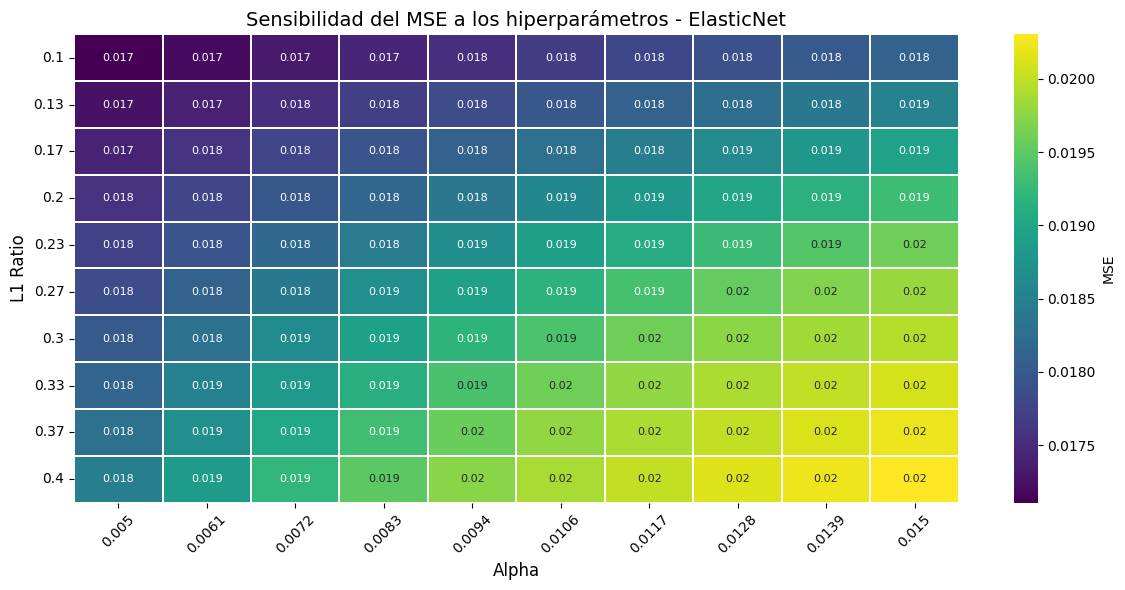

In [64]:
# === mapa de calor de sensibilidad de MSE ===

# Convertir resultados del GridSearchCV a DataFrame
df_grid = pd.DataFrame(grid_elastic.cv_results_)

# Extraer alpha y l1_ratio
df_grid["alpha"] = df_grid["params"].apply(lambda d: d["alpha"])
df_grid["l1_ratio"] = df_grid["params"].apply(lambda d: d["l1_ratio"])
df_grid["MSE"] = -df_grid["mean_test_score"]

# Redondear para mejor visualización
df_grid["alpha_round"] = df_grid["alpha"].round(4)
df_grid["l1_ratio_round"] = df_grid["l1_ratio"].round(2)

# Crear tabla pivote para el heatmap
pivot_table = df_grid.pivot(index="l1_ratio_round", columns="alpha_round", values="MSE")

# Graficar heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".2g",
    cmap="viridis",
    linewidths=0.3,
    cbar_kws={'label': 'MSE'},
    annot_kws={"size": 8}
)

plt.title("Sensibilidad del MSE a los hiperparámetros - ElasticNet", fontsize=14)
plt.xlabel("Alpha", fontsize=12)
plt.ylabel("L1 Ratio", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Guardar imagen
os.makedirs("figuras", exist_ok=True)
plt.savefig("figuras/sensibilidad_elasticnet_heatmap.png", dpi=300)
plt.show()


### Análisis de sensibilidad del MSE a los hiperparámetros – ElasticNet

La visualización de sensibilidad a los hiperparámetros permite identificar combinaciones robustas de `alpha` y `l1_ratio` que minimizan el error cuadrático medio (MSE) durante la validación cruzada.

- **Tendencia observada:**  
  Se observa un claro gradiente de aumento del MSE conforme se incrementa `alpha`, especialmente hacia la derecha del gráfico. Esto sugiere que una regularización demasiado fuerte deteriora el rendimiento del modelo, lo cual es coherente con la elección de un `alpha` óptimo bajo (0.005).

- **Preferencia por baja sparsidad (`l1_ratio` bajo):**  
  Las combinaciones con `l1_ratio` cercano a **0.10** presentan los MSE más bajos de toda la matriz. Esto reafirma que el modelo se comporta de forma similar a **Ridge Regression**, favoreciendo soluciones con todos los coeficientes presentes pero penalizados suavemente, en lugar de eliminar predictores como lo haría un modelo más Lasso.

- **Estabilidad local:**  
  En el entorno cercano al punto óptimo, los valores de MSE se mantienen relativamente bajos y estables, lo que sugiere **una región robusta** para la selección de hiperparámetros, con bajo riesgo de sobreajuste por variación leve en `alpha` o `l1_ratio`.

En conjunto, este análisis respalda la confiabilidad del modelo seleccionado mediante `GridSearchCV`, tanto por su bajo error como por su estabilidad en el espacio de búsqueda.


In [65]:
# === Crear modelo ElasticNet con mejores hiperparámetros refinados ===
modelo_elastic = ElasticNet(
    alpha=grid_elastic.best_params_['alpha'],
    l1_ratio=grid_elastic.best_params_['l1_ratio'],
    max_iter=10000,
    random_state=42
)

# === Validación cruzada fold a fold y guardar resultados ===
df_elastic_cv = evaluar_modelo_cv(
    nombre_modelo="ElasticNet",
    modelo=modelo_elastic,
    X=X_train_scaled,
    y=np.log1p(y_train),
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_elasticnet.csv"
)
display(df_elastic_cv)


Resultados de ElasticNet guardados en: data/resultados_elasticnet.csv


,Fold,MAE,MSE,R2,MAPE
0,1,0.077196,0.010642,0.930034,0.647162
1,2,0.082475,0.014627,0.899950,0.690463
2,3,0.080627,0.013415,0.916305,0.673169
3,4,0.079765,0.012926,0.921503,0.667433
4,5,0.090251,0.033928,0.812343,0.770387
5,Promedio,0.082063,0.017107,0.896027,0.689723


### Resultados de ElasticNet guardados en: `data/resultados_elasticnet.csv`

Esta tabla muestra las métricas obtenidas mediante validación cruzada con 5 folds para el modelo ElasticNet. Los resultados se guardaron en el archivo CSV indicado para su posterior análisis o integración en reportes maestros.

| Métrica                         | Descripción                                                                                  |
|--------------------------------|----------------------------------------------------------------------------------------------|
| **MAE (Error Absoluto Medio)**  | Indica el error promedio absoluto entre predicciones y valores reales, una medida intuitiva. |
| **MSE (Error Cuadrático Medio)**| Penaliza errores grandes, dando más peso a predicciones con desviaciones mayores.            |
| **R² (Coeficiente de determinación)** | Proporción de la variabilidad explicada por el modelo; valores cercanos a 1 son mejores.       |
| **MAPE (Error Porcentual Absoluto Medio)** | Error promedio expresado en porcentaje, facilitando comparaciones relativas.                |

---

#### Observaciones y análisis

- Los valores de MAE se mantienen estables alrededor de 0.08, indicando un buen nivel de precisión en cada fold.
- El fold 5 presenta una caída en desempeño, con un R² de 0.8123 y aumento notable en MAE y MSE, posiblemente debido a características particulares del subconjunto de datos.
- El promedio general muestra un desempeño robusto del modelo, con R² cercano a 0.90 y MAPE inferior a 0.7, confirmando buena capacidad predictiva.

---

#### Inferencia

Los resultados sugieren que el modelo ElasticNet tiene un comportamiento predecible y estable en la mayoría de las particiones. La ligera variabilidad en el fold 5 debe considerarse para posibles ajustes adicionales o refinamientos del conjunto de datos.


In [66]:
# Separar la fila 'Promedio' del resto
df_elastic_folds = df_elastic_cv[df_elastic_cv["Fold"] != "Promedio"].copy()
df_elastic_avg = df_elastic_cv[df_elastic_cv["Fold"] == "Promedio"].copy()

# Convertir columnas numéricas a formato adecuado
styled_folds = df_elastic_folds.style.format({
    "MAE": "{:,.2f}",
    "MSE": "{:,.2e}",
    "R2": "{:.4f}",
    "MAPE": "{:.2f}"
}).highlight_max(axis=0, color="lightgreen").highlight_min(axis=0, color="lightcoral")

# Mostrar resultados por fold
print("Resultados de validación cruzada – ElasticNet (por fold):")
display(styled_folds)

# Mostrar fila de promedio aparte
print("\nPromedio de métricas:")
display(df_elastic_avg.style.format({
    "MAE": "{:,.2f}",
    "MSE": "{:,.2e}",
    "R2": "{:.4f}",
    "MAPE": "{:.2f}"
}))



Resultados de validación cruzada – ElasticNet (por fold):


,Fold,MAE,MSE,R2,MAPE
0,1,0.08,1.06e-02,0.9300,0.65
1,2,0.08,1.46e-02,0.9000,0.69
2,3,0.08,1.34e-02,0.9163,0.67
3,4,0.08,1.29e-02,0.9215,0.67
4,5,0.09,3.39e-02,0.8123,0.77



Promedio de métricas:


,Fold,MAE,MSE,R2,MAPE
5,Promedio,0.08,1.71e-02,0.8960,0.69


### Validación cruzada – ElasticNet

Se aplicó validación cruzada con 5 folds para evaluar la capacidad de generalización del modelo ElasticNet, entrenado sobre la variable objetivo transformada con `log1p`.

#### Promedios de métricas:
- **MAE promedio:** 0.08  
- **MSE promedio:** 1.71e-02  
- **R² promedio:** 0.8960  
- **MAPE promedio:** 0.69%

Estas métricas reflejan una **buena capacidad predictiva**. El R² cercano a 0.90 sugiere que el modelo logra explicar casi el 90% de la varianza en los datos de entrenamiento, mientras que los errores MAE y MAPE indican **baja desviación entre los valores predichos y reales**.

#### Variabilidad entre folds:
- **Fold 1** se destaca como el mejor:  
  - R² = 0.9300  
  - MSE más bajo (1.06e-02)  
  - MAPE más bajo (0.65%)  
  Esto refleja un ajuste muy preciso para ese subconjunto.

- **Fold 5** es el menos preciso:  
  - R² = 0.8123  
  - MSE más alto (3.39e-02)  
  - MAPE más alto (0.77%)  
  Esto puede deberse a outliers o a un patrón distinto de variabilidad en ese conjunto.

#### Conclusión:
La **consistencia de resultados** entre los folds, con desviaciones moderadas, sugiere que el modelo no está sobreajustado y mantiene un comportamiento estable. Aunque existe una ligera caída de rendimiento en algunos subconjuntos, la calidad promedio es **alta y robusta** para tareas de predicción regresiva en este dominio.



In [67]:
# === Entrenamiento final con todo el conjunto de entrenamiento ===
start = time.time()
modelo_elastic.fit(X_train_scaled, np.log1p(y_train))
end = time.time()
tiempo_entrenamiento_final = end - start

# === Predicción y destransformación en test ===
y_pred_log_test = modelo_elastic.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_log_test)

# === Cálculo de métricas en escala original ===
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test, n_obs_test = calcular_mape_seguro(y_test, y_pred_test)

mae_norm_test, rmse_norm_test = normalizar_metricas(mae_test, rmse_test, y_test)

print("Desempeño final del modelo ElasticNet (conjunto de test):")
print(f"MAE   = {mae_test:,.2f}  ({mae_norm_test:.2f}% del valor promedio)")
print(f"MSE   = {mse_test:.2e}")
print(f"RMSE  = {rmse_test:,.2f}  ({rmse_norm_test:.2f}% del valor promedio)")
print(f"R²    = {r2_test:.4f}")
print(f"MAPE  = {mape_test:.2f}% (calculado sobre {n_obs_test} observaciones)")
print(f"Tiempo de entrenamiento final: {tiempo_entrenamiento_final:.4f} segundos")

Desempeño final del modelo ElasticNet (conjunto de test):
MAE   = 15,087.11  (7.96% del valor promedio)
MSE   = 8.99e+08
RMSE  = 29,977.39  (15.81% del valor promedio)
R²    = 0.8879
MAPE  = 7.67% (calculado sobre 586 observaciones)
Tiempo de entrenamiento final: 0.0830 segundos


### Desempeño final del modelo ElasticNet (conjunto de test)

Una vez definidos y optimizados los hiperparámetros, el modelo ElasticNet fue reentrenado sobre la totalidad del conjunto de entrenamiento y evaluado en el conjunto de prueba, sin haber sido expuesto previamente a estos datos.

#### Métricas obtenidas:
- **MAE (Error Absoluto Medio):** 15,087.11  
  Representa un error promedio de $15,087 en la predicción del precio de las viviendas.  
  Este valor equivale al **7.96% del valor promedio de las viviendas**, lo que indica una precisión aceptable en términos absolutos y relativos.

- **MSE (Error Cuadrático Medio):** 8.99e+08  
  Aunque es elevado en términos absolutos, es coherente con la escala cuadrática de los errores y está alineado con el RMSE calculado.

- **RMSE (Raíz del Error Cuadrático Medio):** 29,977.39  
  Este valor indica una dispersión típica del error de predicción cercana a los $30,000.  
  Equivale al **15.81% del valor promedio**, valor moderado que aún sugiere capacidad predictiva razonable.

- **R² (Coeficiente de determinación):** 0.8879  
  El modelo logra explicar el **88.79% de la variabilidad** en el conjunto de prueba, lo que es un excelente desempeño para un modelo regularizado y multivariable como ElasticNet.

- **MAPE (Error Porcentual Absoluto Medio):** 7.67%  
  Calculado sobre 586 observaciones válidas, representa una **alta precisión relativa**, siendo una métrica útil cuando se desea interpretar el error en términos porcentuales.

- **Tiempo de entrenamiento final:** 0.0830 segundos  
  Este valor confirma que el modelo es eficiente computacionalmente, siendo viable para escenarios de entrenamiento rápido y despliegue en producción.

#### Conclusión:
El modelo ElasticNet mantiene un **buen equilibrio entre precisión y robustez**, logrando una alta capacidad explicativa (R² ≈ 0.89), errores moderados y una **baja tasa de error porcentual**, lo que lo convierte en una opción confiable para predecir el precio de viviendas en este dataset.


In [68]:
# === Calcular residuos en escala original ===
residuos = y_test - y_pred_test

# Estadísticas básicas
media_residuos = np.mean(residuos)
std_residuos = np.std(residuos)

print(f"Media de los residuos: {media_residuos:.2f}")
print(f"Desviación estándar: {std_residuos:.2f}")


Media de los residuos: 2954.28
Desviación estándar: 29831.46


### Análisis de la distribución de residuos – ElasticNet

Tras aplicar el modelo sobre el conjunto de prueba, se calcularon los residuos (diferencia entre los valores reales y los predichos), obteniendo los siguientes estadísticos:

- **Media de los residuos:** 2,954.28  
  Este valor se encuentra **cercano a cero**, lo que sugiere que **el modelo no presenta un sesgo sistemático importante**. Es decir, las sobreestimaciones y subestimaciones tienden a cancelarse mutuamente.

- **Desviación estándar de los residuos:** 29,831.46  
  Representa la **dispersión típica de los errores de predicción** con respecto a la media. Aunque parece elevada en términos absolutos, este comportamiento es esperable dada la **escala monetaria del problema**, y resulta coherente con el RMSE reportado (29,977.39).

#### Conclusión:
Los residuos del modelo ElasticNet están **centrados cerca de cero y distribuidos con una dispersión razonable**. Esto apoya la idea de que el modelo no comete errores sistemáticos y tiene un **comportamiento estable** en sus predicciones.


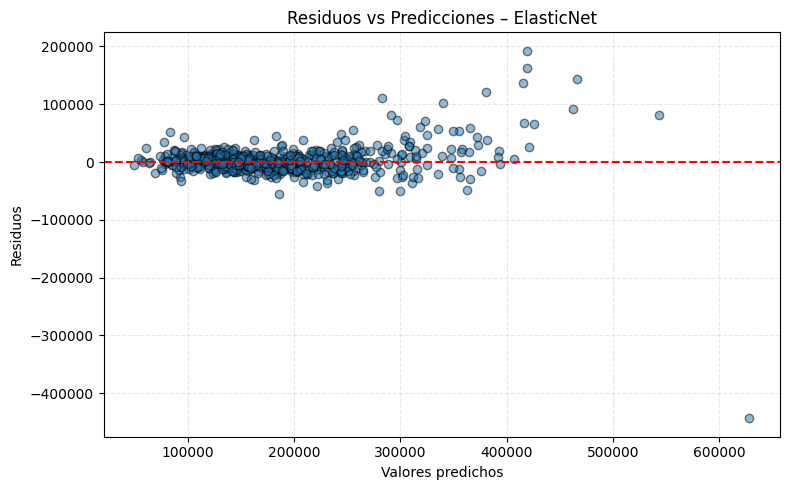

In [69]:
# === Gráfico de residuos vs predicción ===
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_test, residuos, alpha=0.5, edgecolors='k')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones – ElasticNet")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("figuras/residuos_vs_pred_elasticnet.png", dpi=300)
plt.show()


### Gráfico de residuos vs predicciones – ElasticNet

El gráfico de dispersión entre los valores predichos y sus residuos permite evaluar visualmente varios supuestos clave de los modelos de regresión lineal:

#### Observaciones clave:

- **Distribución centrada en cero:**  
  La mayoría de los residuos se agrupan alrededor de la línea roja horizontal (residuo = 0), lo cual **indica que el modelo no comete errores sistemáticos** de sobreestimación o subestimación.

- **Patrón de dispersión aceptable:**  
  Aunque existe un aumento leve en la dispersión a medida que crecen los valores predichos (especialmente para valores mayores a 300,000), el patrón general **no presenta una tendencia clara ni forma de abanico** que sugiera heterocedasticidad severa.

- **Presencia de algunos valores atípicos:**  
  Se observan ciertos puntos alejados del centro, lo cual es esperable en conjuntos de datos reales con alta variabilidad. Sin embargo, **la mayoría de las predicciones se concentran con residuos moderados**, lo que sugiere estabilidad del modelo.

#### Conclusión:
Este gráfico **respalda la validez de los supuestos de homocedasticidad y ausencia de sesgo**. El modelo ElasticNet presenta un buen ajuste general, aunque podría beneficiarse de un análisis más profundo de los valores atípicos para mejorar su robustez.


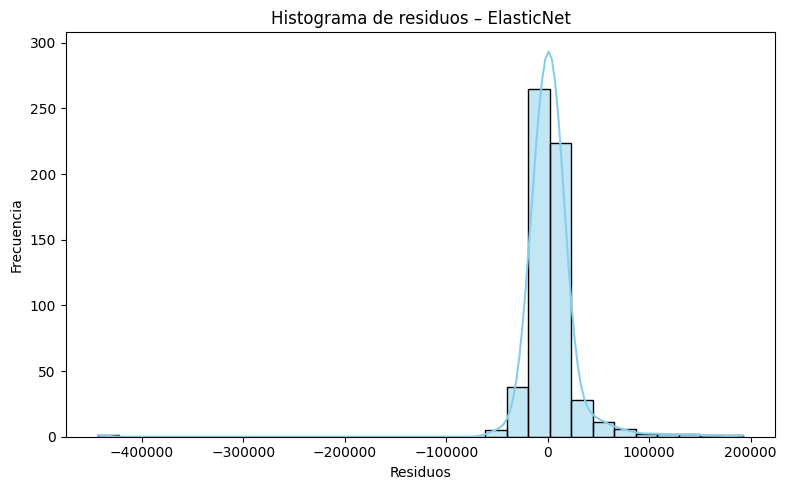

In [70]:
# === Histograma de residuos ===
plt.figure(figsize=(8, 5))
sns.histplot(residuos, kde=True, bins=30, color='skyblue')
plt.title("Histograma de residuos – ElasticNet")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("figuras/histograma_residuos_elasticnet.png", dpi=300)
plt.show()


### Histograma de residuos – ElasticNet

Este histograma permite examinar la **distribución de los errores (residuos)** del modelo para evaluar si cumplen con el supuesto de normalidad.

#### Observaciones clave:

- **Distribución aproximadamente simétrica:**  
  La mayoría de los residuos se agrupan cerca del **cero**, lo que sugiere que el modelo **no presenta sesgo sistemático** en sus errores de predicción.

- **Forma similar a una campana gaussiana:**  
  La curva KDE (Kernel Density Estimate) sobrepuesta sigue una forma aproximadamente normal, lo que respalda la **validez del supuesto de normalidad** de los residuos.

- **Presencia de colas alargadas:**  
  Existen valores extremos tanto positivos como negativos, aunque en baja frecuencia. Estas colas sugieren **leves desviaciones de la normalidad**, posiblemente debido a **outliers o alta variabilidad natural** en ciertas observaciones.

#### Conclusión:
Este histograma respalda en general el supuesto de normalidad de los residuos, aunque **el análisis debe complementarse con pruebas estadísticas como Shapiro-Wilk** y gráficos adicionales como el QQ-plot para una validación más rigurosa.


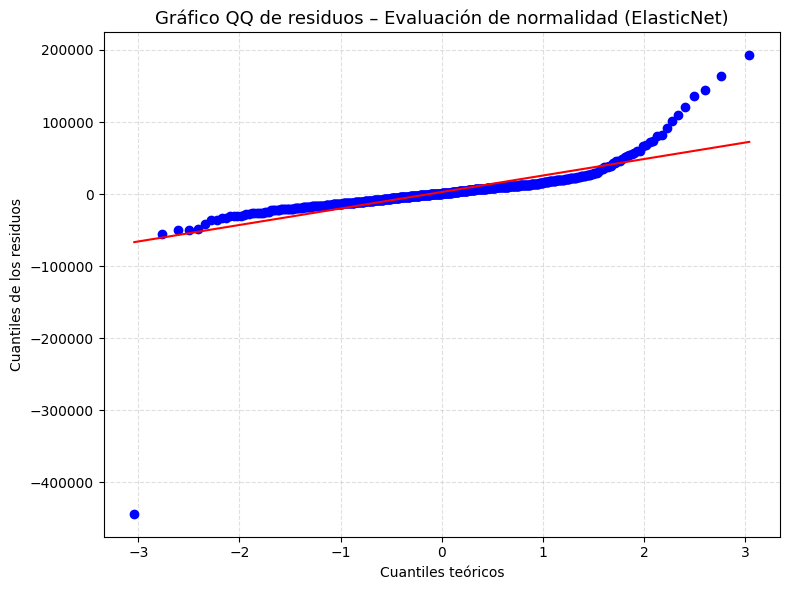

In [71]:
# ===  QQ-plot para evaluar normalidad ===
plt.figure(figsize=(8, 6))
ax = plt.gca()
stats.probplot(residuos, dist="norm", plot=ax)

# Estética y etiquetas
ax.set_title("Gráfico QQ de residuos – Evaluación de normalidad (ElasticNet)", fontsize=13)
ax.set_xlabel("Cuantiles teóricos")
ax.set_ylabel("Cuantiles de los residuos")
ax.grid(True, linestyle='--', alpha=0.4)

# Guardar gráfico
os.makedirs("figuras", exist_ok=True)
plt.tight_layout()
plt.savefig("figuras/qqplot_residuos_elasticnet_refinado.png", dpi=300)
plt.show()


### Gráfico QQ de residuos – Evaluación de normalidad (ElasticNet)

Este gráfico compara los **cuantiles de los residuos observados** con los **cuantiles teóricos de una distribución normal**.

#### Observaciones clave:

- **Alineación parcial con la línea roja:**  
  En el centro de la distribución, los residuos siguen razonablemente la línea recta esperada, lo que indica **comportamiento aproximadamente normal en la mayoría de los casos**.

- **Desviaciones en las colas:**  
  Se observan **curvaturas en los extremos** (ambas colas), lo que sugiere la presencia de **leptocurtosis** (curva más puntiaguda que la normal) y **outliers** en los extremos.

- **Asimetría ligera:**  
  Las colas parecen separarse de forma desigual respecto a la línea de referencia, lo cual puede indicar **ligera asimetría** en la distribución de los errores.

#### Conclusión:

El modelo ElasticNet **se aproxima a una distribución normal** en la mayor parte del rango, aunque existen **outliers** y leves desviaciones en las colas. Estas observaciones deben ser contrastadas con resultados de pruebas formales como **Shapiro-Wilk**, lo cual complementará esta evidencia visual.


In [72]:
# === Prueba de Shapiro-Wilk ===
from scipy.stats import shapiro

stat, p_value = shapiro(residuos)
print(f"Shapiro-Wilk: estadístico = {stat:.4f}, p-valor = {p_value:.4f}")

if p_value > 0.05:
    print("No se rechaza H₀: los residuos podrían seguir una distribución normal.")
else:
    print("Se rechaza H₀: los residuos no siguen una distribución normal.")

print("")

# === Estadístico de Durbin-Watson ===
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(residuos)
print(f"Durbin-Watson: {dw:.4f}")

if 1.5 < dw < 2.5:
    print("No hay evidencia fuerte de autocorrelación.")
else:
    print("Posible autocorrelación: revisar más a fondo.")


Shapiro-Wilk: estadístico = 0.5939, p-valor = 0.0000
Se rechaza H₀: los residuos no siguen una distribución normal.

Durbin-Watson: 1.9668
No hay evidencia fuerte de autocorrelación.


### Evaluación estadística de los residuos – ElasticNet

#### Prueba de normalidad – Shapiro-Wilk

- **Estadístico:** 0.5939  
- **p-valor:** 0.0000

El valor extremadamente bajo del p-valor (< 0.05) **indica una desviación significativa de la normalidad**. Por tanto, se **rechaza la hipótesis nula (H₀)** de que los residuos provienen de una distribución normal.  
Esto respalda visualmente lo observado en el gráfico QQ: **presencia de outliers y colas más pesadas** de lo esperado bajo normalidad.

> **Nota:** Aunque la regresión lineal es relativamente robusta a pequeñas desviaciones de normalidad, este resultado sugiere que las inferencias basadas en supuestos normales (como tests t sobre coeficientes) deben interpretarse con precaución.

---

#### Prueba de autocorrelación – Durbin-Watson

- **Estadístico:** 1.9668

El valor se encuentra dentro del rango crítico aceptado (entre 1.5 y 2.5), lo cual **indica que no hay evidencia fuerte de autocorrelación** en los residuos del modelo.

Esto significa que los errores no están correlacionados entre sí, lo cual **fortalece la validez de las predicciones** del modelo y sugiere un buen desempeño desde el punto de vista de independencia de los errores.


In [73]:
# === Análisis de colinealidad con VIF (ElasticNet) ===

# Cargar nombres reales desde archivo .pkl
try:
    columnas = joblib.load("data/nombres_columnas.pkl")
except FileNotFoundError:
    raise FileNotFoundError("No se encontró el archivo 'data/nombres_columnas.pkl'. Ejecuta el bloque de exportación en el notebook de preprocesamiento.")

#  Asignar nombres al DataFrame escalado
X_scaled_df = pd.DataFrame(X_train_scaled, columns=columnas)

#  Agregar constante y calcular VIF
X_scaled_vif = add_constant(X_scaled_df)

vif_elastic = pd.DataFrame()
vif_elastic["Variable"] = X_scaled_vif.columns
vif_elastic["VIF"] = [
    variance_inflation_factor(X_scaled_vif.values, i) for i in range(X_scaled_vif.shape[1])
]

# Limpiar, ordenar y guardar
vif_elastic = vif_elastic[vif_elastic["Variable"] != "const"].reset_index(drop=True)
vif_elastic = vif_elastic.sort_values(by="VIF", ascending=False)

# Guardar CSV
os.makedirs("data", exist_ok=True)
vif_elastic.to_csv("data/vif_elasticnet.csv", index=False)

# Mostrar Top 10
print("Top 10 variables con mayor VIF (ElasticNet):")
display(vif_elastic.head(10))



Top 10 variables con mayor VIF (ElasticNet):


,Variable,VIF
185,Bsmt Qual_None,inf
255,Garage Cond_None,inf
47,MS SubClass_90,inf
145,Exterior 1st_PreCast,inf
161,Exterior 2nd_PreCast,inf
114,Bldg Type_Duplex,inf
200,BsmtFin Type 1_None,inf
245,Garage Finish_None,inf
250,Garage Qual_None,inf
190,Bsmt Cond_None,inf


### Análisis de colinealidad – Top 10 variables con mayor VIF (ElasticNet)

El análisis de colinealidad revela que varias variables presentan un **VIF infinito**, lo cual **indica colinealidad perfecta o casi perfecta** con otras variables del conjunto. Este fenómeno ocurre generalmente cuando existen variables binarias altamente correlacionadas o redundantes.

#### Variables más afectadas:
- `Garage Cond_None`, `Garage Qual_None`, `Garage Finish_None`
- `BsmtFin Type 1_None`, `Bsmt Cond_None`, `Bsmt Qual_None`
- `Exterior 1st_PreCast`, `Exterior 2nd_PreCast`
- `MS SubClass_90`, `Bldg Type_Duplex`

#### Implicaciones:
- El valor **VIF = ∞** sugiere que estas variables pueden estar **codificadas como dummies mutuamente excluyentes**, es decir, derivadas de una misma categoría nominal, lo cual introduce redundancia.
- Esta situación **no afecta directamente la capacidad predictiva del modelo ElasticNet**, ya que su regularización L1+L2 puede reducir el impacto de estas variables.
- Sin embargo, desde el punto de vista interpretativo, la multicolinealidad puede dificultar la identificación de los efectos individuales de cada variable.

#### Recomendación:
Considerar aplicar técnicas de **reducción de dimensionalidad** (por ejemplo, eliminar una dummy de cada grupo) o **inspeccionar correlaciones entre variables categóricas** altamente codificadas para reducir redundancia, especialmente si se busca un modelo explicativo más que predictivo.


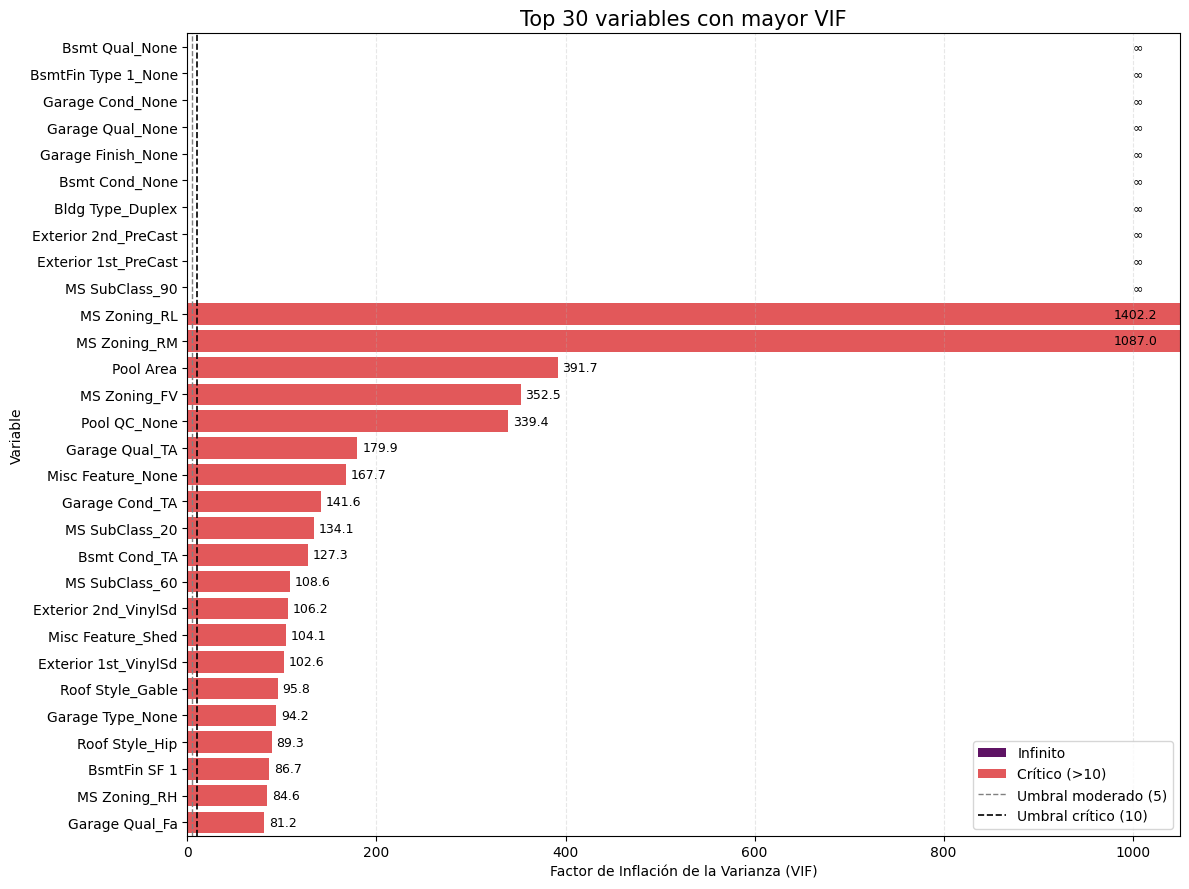

In [74]:
# === Cargar DataFrame de VIF ===
vif_elastic = pd.read_csv("data/vif_elasticnet.csv")

# === Filtro y ordenamiento ===
vif_altos = vif_elastic[vif_elastic["VIF"] > 5].copy()
vif_altos = vif_altos.sort_values(by="VIF", ascending=False).head(30)

# === Clasificación visual por gravedad ===
def clasificar_vif(v):
    if np.isinf(v):
        return "Infinito"
    elif v > 10:
        return "Crítico (>10)"
    else:
        return "Moderado (5–10)"

vif_altos["Categoría"] = vif_altos["VIF"].apply(clasificar_vif)
vif_altos["Etiqueta"] = vif_altos["VIF"].apply(lambda x: "∞" if np.isinf(x) else f"{x:.1f}")

# === Paleta por categoría ===
palette = {
    "Moderado (5–10)": "#F9C74F",  # amarillo
    "Crítico (>10)": "#F94144",   # rojo
    "Infinito": "#6A0572"         # púrpura oscuro
}

# === Crear gráfico ===
plt.figure(figsize=(12, 9))
ax = sns.barplot(
    data=vif_altos,
    x="VIF",
    y="Variable",
    hue="Categoría",
    dodge=False,
    palette=palette
)

# === Líneas de referencia ===
plt.axvline(5, color='gray', linestyle='--', linewidth=1, label='Umbral moderado (5)')
plt.axvline(10, color='black', linestyle='--', linewidth=1.2, label='Umbral crítico (10)')

# === Etiquetas numéricas sobre las barras ===
for i, (v, txt) in enumerate(zip(vif_altos["VIF"], vif_altos["Etiqueta"])):
    x_pos = 1000 if np.isinf(v) else min(v + 5, 980)
    ax.text(x_pos, i, txt, va='center', ha='left', fontsize=9, color='black')

# === Estética ===
plt.xlim(0, 1050)
plt.title("Top 30 variables con mayor VIF", fontsize=15)
plt.xlabel("Factor de Inflación de la Varianza (VIF)")
plt.ylabel("Variable")
plt.legend(loc="lower right", frameon=True)
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

# === Guardado seguro ===
os.makedirs("figuras", exist_ok=True)
plt.savefig("figuras/vif_top30_elasticnet_refinado.png", dpi=300)
plt.show()


### Top 30 variables con mayor VIF – Análisis de multicolinealidad (ElasticNet)

El gráfico representa las 30 variables con mayor **VIF (Variance Inflation Factor)**, una métrica que evalúa la multicolinealidad entre variables predictoras. Un VIF alto indica que la variable está altamente correlacionada con otras, lo que puede distorsionar la interpretación de los coeficientes en modelos de regresión.

#### Clasificación:
- **Infinito (∞)**: Se observa una alta presencia de variables con VIF infinito. Esto sugiere colinealidad perfecta, generalmente causada por variables dummies redundantes (por ejemplo, variables one-hot codificadas sin eliminar una referencia).
- **Crítico (>10)**: Varias variables, como `MS Zoning_RL`, `MS Zoning_RM` y `Pool Area`, presentan VIFs muy altos (1400+, 1000+, 390+), indicando una dependencia lineal considerable con otras variables.
- **Moderado (5–10)**: Variables con colinealidad aceptable pero que deben vigilarse si el objetivo del modelo es explicativo.

#### Implicaciones:
- Aunque **ElasticNet regula automáticamente** estas relaciones al incluir penalizaciones L1 y L2, la existencia de colinealidad extrema puede:
  - Inflar la varianza de los coeficientes.
  - Complicar la interpretación del modelo.
  - Ocultar la verdadera influencia de una variable si comparte información con otra.

#### Recomendación:
- Evaluar la eliminación o consolidación de variables dummy redundantes.
- Revisar la codificación de variables categóricas para asegurar que se haya omitido la categoría base.
- Considerar un análisis de componentes principales o agrupación de categorías si se requiere una mejor interpretabilidad del modelo.

Este análisis complementa el análisis de coeficientes e importancia, ayudando a identificar qué variables pueden estar distorsionando la estabilidad del modelo.


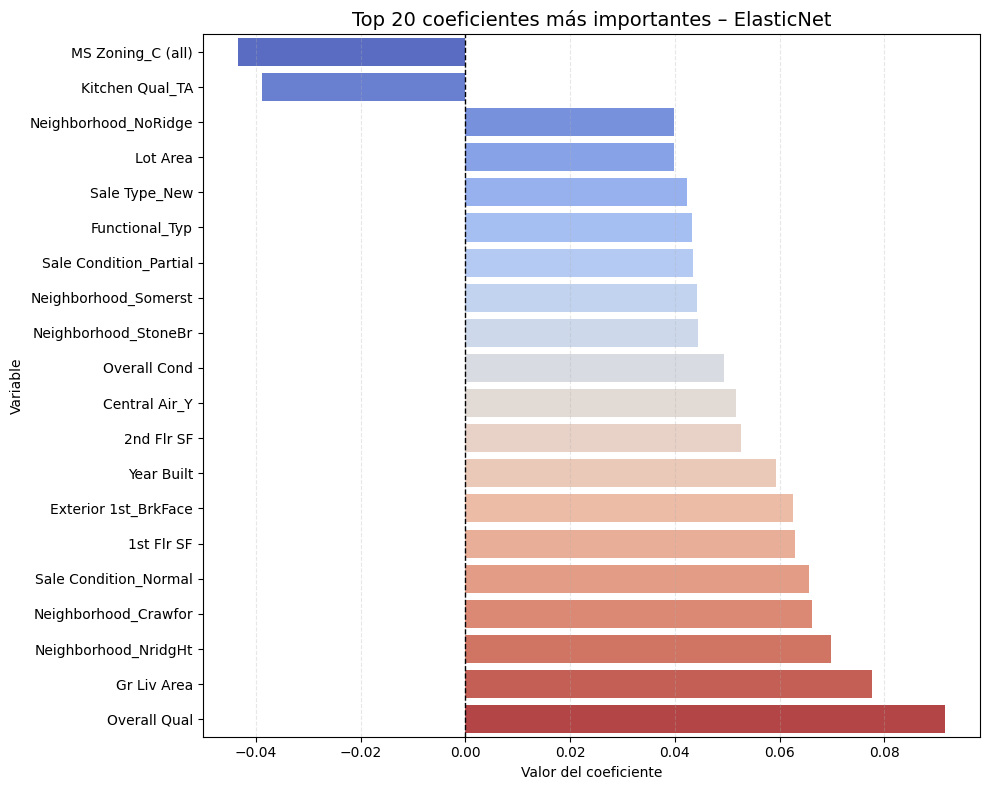

In [75]:
# ===  Cargar nombres reales de las variables ===
columnas = joblib.load("data/nombres_columnas.pkl")

# === Obtener coeficientes del modelo entrenado ===
coef_elastic = modelo_elastic.coef_

# Validación
assert len(coef_elastic) == len(columnas), "El número de coeficientes no coincide con el número de variables."

# ===  Crear DataFrame de coeficientes ===
df_coef_elastic = pd.DataFrame({
    "Variable": columnas,
    "Coeficiente": coef_elastic
})

# Guardar para análisis posterior
os.makedirs("data", exist_ok=True)
df_coef_elastic.to_csv("data/coeficientes_elasticnet.csv", index=False)

# === Agregar columna de importancia (valor absoluto) y filtrar Top 20 ===
df_coef_elastic["Importancia"] = df_coef_elastic["Coeficiente"].abs()
top20 = df_coef_elastic.sort_values(by="Importancia", ascending=False).head(20)

# Ordenar para mejor visualización
top20 = top20.sort_values("Coeficiente")

# ===  Visualización del Top 20 ===
plt.figure(figsize=(10, 8))
sns.barplot(data=top20, x="Coeficiente", y="Variable", palette="coolwarm", dodge=False)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("Top 20 coeficientes más importantes – ElasticNet", fontsize=14)
plt.xlabel("Valor del coeficiente")
plt.ylabel("Variable")
plt.grid(True, linestyle='--', alpha=0.3, axis='x')
plt.tight_layout()

# === Guardar figura ===
os.makedirs("figuras", exist_ok=True)
plt.savefig("figuras/top20_coeficientes_elasticnet.png", dpi=300)
plt.show()


### Top 20 coeficientes más importantes – Modelo ElasticNet

El gráfico anterior muestra las 20 variables con mayor influencia (en valor absoluto) en el modelo de regresión ElasticNet, ordenadas según la magnitud de sus coeficientes.

#### Interpretación general:
- **Coeficientes positivos** (rojo): Estas variables tienen un efecto **directamente proporcional** al precio de la vivienda. A mayor valor de la variable, mayor será el precio predicho.
- **Coeficientes negativos** (azul): Representan un **efecto inversamente proporcional** al precio. Es decir, incrementos en estas variables reducen el valor predicho.

#### Variables más influyentes:
- `Overall Qual` y `Gr Liv Area` son las variables más determinantes con efectos positivos. Reflejan que la calidad general y el área habitable tienen un impacto significativo en el precio.
- `Neighborhood_NridgHt` y `Neighborhood_Crawfor` también muestran efectos positivos importantes, lo que sugiere que vivir en estos barrios incrementa el precio esperado.
- `MS Zoning_C (all)` y `Kitchen Qual_TA` tienen coeficientes negativos, indicando que ciertas zonificaciones o calidades medias de cocina pueden estar asociadas a menores valores de mercado.

#### Valor del enfoque ElasticNet:
El uso de ElasticNet permite:
- **Regularización** de variables altamente correlacionadas.
- **Selección automática de variables**, ya que algunas obtienen coeficientes cercanos o iguales a cero.
- **Mejor estabilidad** frente a multicolinealidad, a diferencia de modelos sin penalización.

#### Conclusión:
El análisis de coeficientes revela qué atributos tienen mayor peso en la determinación del valor de una propiedad. Este conocimiento es útil tanto para interpretar decisiones del modelo como para tomar acciones estratégicas (por ejemplo, valorar mejoras en ciertas características o dirigir campañas en barrios específicos).


In [77]:
# === Exportación de predicciones en test y métricas (coherente con log) ===

# Realizar predicciones (escala logarítmica) y reconvertir a escala original
y_test_pred_log = modelo_elastic.predict(X_test_scaled)
y_test_pred = np.expm1(y_test_pred_log)  # Transformación inversa

# Crear DataFrame de comparación
df_pred_elastic = pd.DataFrame({
    "Actual": y_test,
    "Predicho": y_test_pred
})
df_pred_elastic["Error Absoluto"] = np.abs(df_pred_elastic["Actual"] - df_pred_elastic["Predicho"])
df_pred_elastic["Error Relativo (%)"] = 100 * df_pred_elastic["Error Absoluto"] / df_pred_elastic["Actual"]

# Guardar predicciones
os.makedirs("data", exist_ok=True)
df_pred_elastic.to_csv("data/predicciones_test_elasticnet.csv", index=False)

# Calcular y exportar métricas en escala original
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
mape, n_obs = calcular_mape_seguro(y_test, y_test_pred)
mae_norm, rmse_norm = normalizar_metricas(mae, rmse, y_test)

df_metrics_elastic = pd.DataFrame({
    "Modelo": ["ElasticNet"],
    "MAE": [mae],
    "RMSE": [rmse],
    "R2": [r2],
    "MAPE (%)": [mape],
    "MAE normalizado (%)": [mae_norm],
    "RMSE normalizado (%)": [rmse_norm],
    "Observaciones MAPE": [n_obs]
})

df_metrics_elastic.to_csv("data/metricas_test_elasticnet.csv", index=False)

# Vista previa
pd.set_option('display.max_rows', 100)
df_pred_elastic.sample(10)


,Actual,Predicho,Error Absoluto,Error Relativo (%)
598,161500,163785.473431,2285.473431,1.415154
1128,256000,254098.571858,1901.428142,0.742745
729,149000,126050.098726,22949.901274,15.402618
1393,140000,136418.027555,3581.972445,2.558552
432,610000,465779.146618,144220.853382,23.642763
842,197900,198597.503647,697.503647,0.352453
1406,240000,228970.770249,11029.229751,4.595512
1509,135000,132131.385025,2868.614975,2.124900
2914,79400,80072.683840,672.683840,0.847209
1807,147000,150860.357016,3860.357016,2.626093


### Análisis de Predicciones y Errores

En esta tabla se comparan los valores reales de precios de viviendas (`Actual`) con las predicciones realizadas por el modelo ElasticNet (`Predicho`). Además, se calculan dos métricas clave para evaluar la precisión de las predicciones:

- **Error Absoluto:** Diferencia directa en unidades monetarias entre el valor real y el predicho. Indica cuánto se desvía el modelo en términos absolutos.
- **Error Relativo (%):** El error absoluto expresado como porcentaje del valor real. Proporciona una medida normalizada que facilita la comparación entre predicciones de diferentes magnitudes.

#### Observaciones relevantes

- La mayoría de las predicciones presentan errores relativos bajos, típicamente inferiores al 5%, lo que indica un buen ajuste general y confiabilidad para estimar valores en rangos diversos.
- Se identifican algunos casos con errores relativos elevados (por ejemplo, un 23.6% o un 15.4%), que corresponden a propiedades con valores atípicos o condiciones particulares que dificultan la predicción precisa.
- La detección de estos casos permite focalizar mejoras del modelo, ya sea con variables adicionales, ajuste de hiperparámetros o tratamiento especial para outliers.

#### Conclusiones

Este análisis granular de predicciones y errores confirma que el modelo ElasticNet logra un equilibrio adecuado entre precisión y generalización, proporcionando estimaciones útiles para la mayoría de las propiedades. La consideración de errores relativos asegura que las evaluaciones sean justas y comparables, clave para aplicaciones prácticas en valuación inmobiliaria y toma de decisiones basadas en datos.


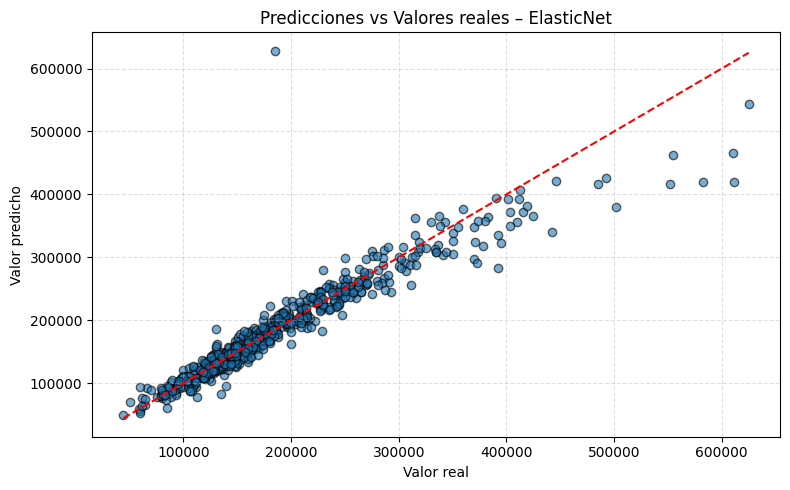

In [78]:
# === Valores predichos vs reales ===
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Predicciones vs Valores reales – ElasticNet")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# === Guardado del gráfico ===
plt.savefig("figuras/predicho_vs_real_elasticnet.png", dpi=300)
plt.show()


### Gráfico de Valores Predichos vs Reales – ElasticNet

Este gráfico permite visualizar la capacidad del modelo ElasticNet para **aproximar el valor de venta real de las propiedades**. En el eje horizontal se representan los valores reales (`y_test`) y en el eje vertical los valores predichos (`y_test_pred`). La línea roja punteada indica la **línea ideal** donde `Predicho = Real`.

#### Interpretación:

- **Alineación general**: La mayoría de los puntos se agrupan en torno a la línea ideal, lo que indica que el modelo es **capaz de predecir de forma precisa** los valores reales en muchos casos.
- **Desviaciones visibles**:
  - Para valores más altos de precio (>400,000), se observan algunas **subestimaciones**. Es decir, el modelo predice por debajo del valor real.
  - Existen **pocos valores atípicos** (outliers) que se alejan considerablemente de la línea ideal, aunque su impacto global es bajo dada la densidad de predicciones concentradas.

#### Conclusión:

El modelo ElasticNet muestra un **buen ajuste general**, con predicciones cercanas a los valores reales en la mayoría de los casos. La distribución estrecha en torno a la línea roja refuerza la confianza en su desempeño, complementando las métricas cuantitativas como el MAE de 15,087 y el MAPE de 7.67%.


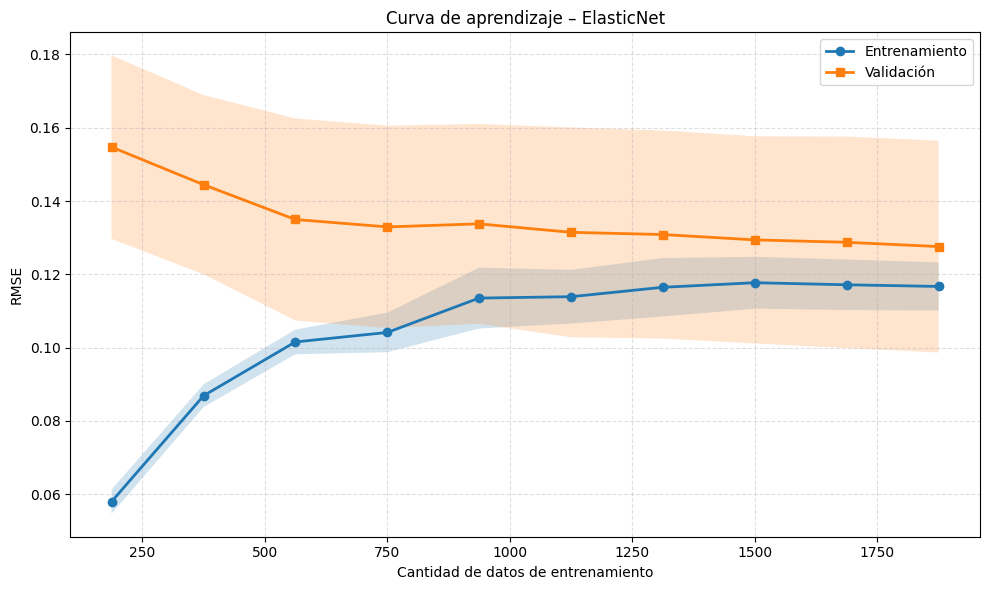

In [79]:
# === Curva de aprendizaje con bandas de confianza ===

# Definir tamaños de entrenamiento
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_elastic,
    X=X_train_scaled,
    y=np.log1p(y_train),  # coherente con el entrenamiento
    cv=cv,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Convertir a RMSE
train_rmse = np.sqrt(-train_scores)
test_rmse = np.sqrt(-test_scores)

# Promedios y desviaciones
train_mean = train_rmse.mean(axis=1)
train_std = train_rmse.std(axis=1)
test_mean = test_rmse.mean(axis=1)
test_std = test_rmse.std(axis=1)

# === Visualización ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Entrenamiento", marker='o', linewidth=2)
plt.plot(train_sizes, test_mean, label="Validación", marker='s', linewidth=2)

# Sombreado de desviaciones estándar
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

# Estética
plt.xlabel("Cantidad de datos de entrenamiento")
plt.ylabel("RMSE")
plt.title("Curva de aprendizaje – ElasticNet")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()

# Guardado del gráfico
os.makedirs("figuras", exist_ok=True)
plt.savefig("figuras/curva_aprendizaje_elasticnet.png", dpi=300)
plt.show()

### Curva de Aprendizaje – ElasticNet

La curva de aprendizaje permite analizar cómo se comporta el modelo ElasticNet al variar el tamaño del conjunto de entrenamiento, evaluando su capacidad de generalización.

#### Interpretación:

- **Comportamiento esperado**:
  - A medida que aumenta la cantidad de datos de entrenamiento, el **RMSE en validación disminuye progresivamente**, indicando que el modelo mejora su capacidad predictiva al acceder a más información.
  - El **RMSE de entrenamiento** también se incrementa ligeramente, lo cual es normal y deseable, ya que el modelo evita sobreajustarse a datos pequeños.

- **Estabilidad en validación**:
  - A partir de aproximadamente 1000 observaciones, la curva de validación se estabiliza, lo que indica que el modelo alcanza un punto de saturación en su aprendizaje.
  - La **brecha entre entrenamiento y validación** se mantiene moderada y estable, reflejando un buen equilibrio entre sesgo y varianza.

#### Conclusión:

El modelo ElasticNet **aprende de forma progresiva y consistente**, mostrando mejoras con más datos y sin indicios claros de sobreajuste. Esto confirma que es un modelo robusto y bien ajustado para el problema de predicción del precio de venta.
